In this file, high resolution patches are predicted by the neural network for the validation years, for patches that are on the same location as one of the training patches. It also contains code to plot the results. Since the TFRecord files contain no coordinate information, this information is retrieved by exporting a geotiff map from GEE with lon-lat bands. By cutting out the same patch as for the precipitation data, coordinate data is retrieved and added to the data array. 

In [1]:
!pip install --upgrade google-api-python-client   #install Python API
!python -c "from oauth2client import crypt"
!pip install gcsfs
!pip install "natsort==7.0.0"


Requirement already up-to-date: google-api-python-client in /opt/conda/lib/python3.7/site-packages (1.12.8)


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
#import ee
import pandas as pd
import IPython.display as display
from natsort import natsorted 
import tensorflow as tf


Load in patches for downscaling, and geotiff with coordinate data

In [3]:
files_low = !gsutil ls -r 'gs://era-ml-upressing/tfrecord_files_predL'
files_high = !gsutil ls -r 'gs://era-ml-upressing/tfrecord_files_predH'

coord_low = 'gs://era-ml-upressing/coordinates/lonlat64.tfrecord.gz'
coord_high = 'gs://era-ml-upressing/coordinates/lonlat256.tfrecord.gz'
coordinates_low = tf.data.TFRecordDataset(coord_low, compression_type='GZIP')
coordinates_high = tf.data.TFRecordDataset(coord_high, compression_type='GZIP')

# skip .. and .
fileslow = natsorted(files_low[2:])
fileshigh= natsorted(files_high[2:])

#use small part of all data
files_low1 = tf.data.TFRecordDataset(fileslow, compression_type='GZIP')
files_high1 = tf.data.TFRecordDataset(fileshigh, compression_type='GZIP')

In [4]:
#parse serialized tensors, needed for TFRecords. From byte->float and shape image
def parse_example_high(raw_example):
  shape = [512,512,1]
  featuresDict={'latitude': tf.io.FixedLenFeature(shape=shape, dtype=tf.float32),
                'longitude': tf.io.FixedLenFeature(shape=shape, dtype=tf.float32)}
  example = tf.io.parse_single_example(raw_example, featuresDict)
  return example
  
def parse_example_low(raw_example):
  shape = [128,128,1]
  featuresDict={'longitude': tf.io.FixedLenFeature(shape=shape, dtype=tf.float32),
                'latitude': tf.io.FixedLenFeature(shape=shape, dtype=tf.float32)}
  example = tf.io.parse_single_example(raw_example, featuresDict)
  return example

coordinates_L = coordinates_low.map(parse_example_low)
coordinates_H = coordinates_high.map(parse_example_high)

In [5]:
#get coordinates of patch, later on needed to plot the results
tile = list(coordinates_H)[2]
padding = 512 // 8

patch = {}
patch['longitude'] = tile['longitude'][padding*3:-padding*1, padding*2:-padding*2]
patch['latitude'] = tile['latitude'][padding*3:-padding*1, padding*2:-padding*2]
patch['latitude'].numpy().max()

72.62879

In [6]:
# assert that files match (check lengths)
def parseTensor(x):
  return tf.io.parse_tensor(x, out_type=tf.float32)

pred_low = files_low1.map(parseTensor).take(1461)
pred_high = files_high1.map(parseTensor).take(1461)
low = pred_low.batch(1)

In [7]:
#load custom loss function
from keras import backend as K

def loss_function(y_true, y_pred):
    return (K.mean(K.square(K.cast(K.greater(y_true, 0.7), tf.float32) * (y_pred - y_true)*4))) + (K.mean(K.square(K.cast(K.less_equal(y_true, 0.7), tf.float32) * (y_pred - y_true))))
 

Using TensorFlow backend.


In [8]:
#load model, compile =False because we use a custom loss function
model = tf.keras.models.load_model('gs://era-ml-upressing/saved_models/autoencoder29', compile=False) #eerst20


In [9]:
#compile model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.00001), loss=loss_function)

In [10]:
#predict high resolution map, rescale back to original value range
import pickle
prediction = model.predict(low)
prediction_rescaled=[]
for image in prediction:
    f = np.ndarray.flatten(image)
    g = f.reshape(-1,1)   
    scaler = pickle.load(open('scaler_new.pkl', 'rb'))              #scale data back to original value range
    h = scaler.inverse_transform(g)
    i = h ** 5
    prediction_rescaled.append(i.reshape((256,256)))

low_rescaled=[]
high_rescaled=[]
def rescale(image, shape):
    num = image.numpy()
    f = np.ndarray.flatten(num)
    g = f.reshape(-1,1)   
    scaler = pickle.load(open('scaler_new.pkl', 'rb'))              #scale data back to original value range
    h = scaler.inverse_transform(g)
    i = h ** 5
    return i.reshape((shape, shape))
for x in pred_low:
    low_rescaled.append(rescale(x, shape=64))
for x in pred_high:
    high_rescaled.append(rescale(x, shape=256))



In [11]:
#create xarray with all downscaled images and low resolution images
import xarray
from dateutil.parser import parse
xarray1 = xarray.DataArray(data=prediction_rescaled[0])
xarray2= xarray.DataArray(data=low_rescaled[0])

In [14]:
dates=[]

In [16]:
#Change date range to pair with your patches
import calendar
yearStart=1990
yearEnd=1991
monthStart = 1
monthEnd = 12
for year in list(range(yearStart, yearEnd + 1)):
    for month in list(range(monthStart, monthEnd + 1)):
        numberOfDays = calendar.monthrange(year, month)[1]
        for day in list(range(1,numberOfDays+1)):
          date = '%04d%02d%02d' % (year, month, day)
          dates.append(date)          

In [18]:
len(dates)

1461

In [19]:
#add dates to data precipitation
xarray1 = xarray1.expand_dims(time=[parse(dates[0])], axis=0)
xarray2 = xarray2.expand_dims(time=[parse(dates[0])], axis=0)

In [ ]:
for i,x in enumerate(ls[1:]):
    print(i)

In [20]:
for i,x in enumerate(prediction_rescaled[1:]):
    data_array_new = xarray.DataArray(data=x)
    data_array_new = data_array_new.expand_dims(time=[parse(dates[i+1])], axis=0)
    xarray1 = xarray.concat([xarray1, data_array_new], dim='time')  
for i,x in enumerate(low_rescaled[1:]):
    data_array_new2 = xarray.DataArray(data=x)
    data_array_new2 = data_array_new2.expand_dims(time=[parse(dates[i+1])], axis=0)
    xarray2 = xarray.concat([xarray2, data_array_new2], dim='time')      
    

In [26]:
#define scaling factor, apply scaling factor.
sumpred = xarray1.sum(dim=('dim_0','dim_1'))
sumx = xarray2.sum(dim=('dim_0','dim_1'))
factor= (sumx*16)/sumpred
xarray3 = xarray1 * factor

In [28]:
(xarray3/xarray1)[2]

<xarray.DataArray (dim_0: 256, dim_1: 256)>
array([[1.2293547, 1.2293547, 1.2293547, ..., 1.2293549, 1.2293547,
        1.2293547],
       [1.2293547, 1.2293549, 1.2293547, ..., 1.2293547, 1.2293547,
        1.2293547],
       [1.2293547, 1.2293547, 1.2293547, ..., 1.2293547, 1.2293547,
        1.2293547],
       ...,
       [1.2293547, 1.2293547, 1.2293547, ..., 1.2293547, 1.2293547,
        1.2293549],
       [1.2293547, 1.2293547, 1.2293547, ..., 1.2293547, 1.2293547,
        1.2293547],
       [1.2293547, 1.2293547, 1.2293547, ..., 1.2293547, 1.2293547,
        1.2293547]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1980-01-03
Dimensions without coordinates: dim_0, dim_1

In [29]:
#add coordinate data to precipitation data
xarray4 = xarray3.assign_coords({'dim_1': np.array(patch['longitude'][0]).reshape(256), 'dim_0':  np.array(patch['latitude'][:,0]).reshape(256)})

In [30]:
dataset= xarray4.to_dataset(name='precipitation')

In [31]:
dataset

<xarray.Dataset>
Dimensions:        (dim_0: 256, dim_1: 256, time: 1461)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1991-12-31
  * dim_1          (dim_1) float32 -41.906406 -41.636913 ... 26.545218 26.81471
  * dim_0          (dim_0) float32 72.62879 72.3593 ... 4.177166 3.9076715
Data variables:
    precipitation  (time, dim_0, dim_1) float32 6.480816e-05 ... 8.256267e-05

In [32]:
#change names
da=dataset.rename({'dim_1': 'longitude', 'dim_0': 'latitude'})

In [33]:
#add metadata
da.latitude.attrs['units'] = 'degrees_north'
da.latitude.attrs['standard_name'] = 'latitude'
da.latitude.attrs['long_name'] = 'latitude'
da.longitude.attrs['units'] = 'degrees_east'
da.longitude.attrs['standard_name'] = 'longitude'
da.longitude.attrs['long_name'] = 'longitude'
da.time.attrs['standard_name'] = 'time'
da.time.attrs['long_name'] = 'time'
#da = da[0:200, ...]
da.attrs['Conventions'] = 'CF-1.8'
da.precipitation.attrs['units'] = 'm'
#da = da.drop('band')


In [34]:
da

<xarray.Dataset>
Dimensions:        (latitude: 256, longitude: 256, time: 1461)
Coordinates:
  * time           (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1991-12-31
  * longitude      (longitude) float32 -41.906406 -41.636913 ... 26.81471
  * latitude       (latitude) float32 72.62879 72.3593 ... 4.177166 3.9076715
Data variables:
    precipitation  (time, latitude, longitude) float32 6.480816e-05 ... 8.256...
Attributes:
    Conventions:  CF-1.8

In [38]:
#get part of dataset between two dates
ds = da.sel(time=slice("1990-01-01", "1991-12-31"))

In [39]:
ds

<xarray.Dataset>
Dimensions:        (latitude: 256, longitude: 256, time: 730)
Coordinates:
  * time           (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1991-12-31
  * longitude      (longitude) float32 -41.906406 -41.636913 ... 26.81471
  * latitude       (latitude) float32 72.62879 72.3593 ... 4.177166 3.9076715
Data variables:
    precipitation  (time, latitude, longitude) float32 0.0002232951 ... 8.256...
Attributes:
    Conventions:  CF-1.8

In [40]:
#convert dataset to netcdf file
ds.to_netcdf('downscaledERA20C-1990-1991_EU_new.nc')

In [42]:
#copy to bucket
!gsutil cp 'downscaledERA20C-1990-1991_EU_new.nc' gs://era-ml-upressing/wflow_files

Copying file://downscaledERA20C-1990-1991_EU_new.nc [Content-Type=application/x-netcdf]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][182.5 MiB/182.5 MiB]                                                
Operation completed over 1 objects/182.5 MiB.                                    


In [16]:
#calculate RMSE downscaled images
dif=[]
dif2=[]
RMSE=[]
for i in range(len(prediction_rescaled)):
    flat_pred=np.ndarray.flatten(prediction_rescaled[i])
    flat_high=np.ndarray.flatten(high_rescaled[i])
    dif1 = flat_high- flat_pred
    dif.append(dif1.reshape(256,256))
    RMSE.append((np.sqrt(dif[i] **2)).mean()*1000)
    
#    dif2.append(np.ndarray.flatten(prediction_rescaled[i]) - np.ndarray.flatten(downscaled_flat[i]).reshape(256,256))

In [48]:
!pip install scikit-image

In [19]:
#calculate RMSE interpolated images
import xarray
import numpy as np
from skimage import transform

dif2=[]
inter=[]
RMSEint=[]
for x,i in enumerate(low_rescaled):
    image= transform.resize(i, output_shape=(256,256), order=1)
    flat_int= np.ndarray.flatten(image)
    flat_high=np.ndarray.flatten(high_rescaled[x])
    difint = flat_high-flat_int
    dif2.append(difint.reshape(256,256))
    inter.append(image)
    RMSEint.append((np.sqrt(dif2[x]**2)).mean()*1000)
    

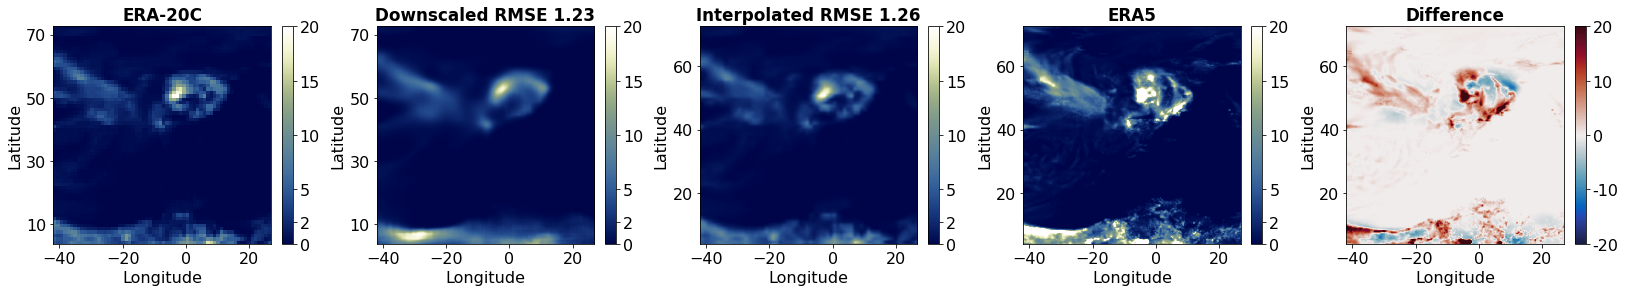

In [104]:
#plot results: low and high resolution, downscaled and interpolated and a difference map (high-downscaled) 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import davos
!pip install cmocean
import cmocean
from rasterio.plot import show
norm= colors.PowerNorm(gamma=0.5)
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 16
fig, axes = plt.subplots(1,5, figsize=(28,4))
day= np.s_[165]


show(low_rescaled[day]*1000, ax=axes[0], title='ERA-20C', vmin=0, vmax=20,  cmap=davos.davos_map, interpolation=None) 
show(prediction_rescaled[day]*1000, ax=axes[1], title='Downscaled RMSE {:.2f}'.format((np.sqrt(dif[day] **2)).mean()*1000), vmin=0, vmax=20,  cmap=davos.davos_map, interpolation=None) 
show(inter[day]*1000, ax=axes[2], title='Interpolated RMSE {:.2f}'.format((np.sqrt(dif2[day] **2)).mean()*1000), vmin=0, vmax=20,  cmap=davos.davos_map, interpolation=None)
show(high_rescaled[day]*1000, ax=axes[3], title='ERA5', vmin=0, vmax=20,  cmap=davos.davos_map, interpolation=None, extent=[-41.9, 26.8, 3.9, 72.6])
show(dif[day]*1000, ax=axes[4], title='Difference', vmin=-20, vmax=20, extent=[-41.9, 26.8, 3.9, 72.6], cmap=cmocean.cm.balance, interpolation=None)   

image=[low_rescaled[day]*1000, prediction_rescaled[day]*1000]
for i in [0,1]:
    ax=axes[i]
    im = ax.get_images()[0]
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.imshow(image[i], extent=[-41.9, 26.8, 3.9, 72.6],  cmap=davos.davos_map)
    ax.set_xticks(ticks=[-40, -20, 0, 20])
    ax.set_yticks(ticks=[10, 30, 50, 70])
    plt.colorbar(im, ax=ax, orientation='vertical', ticks=[0, 2, 5, 10,15,20], format='%.0f', fraction=0.046, pad=0.04)

    
im2 = axes[2].get_images()[0] 

axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[2], orientation='vertical', ticks=[0, 2, 5, 10,15,20], format='%.0f', fraction=0.046, pad=0.04)
axes[2].imshow(inter[day]*1000, extent=[-41.9, 26.8, 3.9, 72.6], cmap=davos.davos_map)


im3 = axes[3].get_images()[0] 

axes[3].set_xlabel('Longitude')
axes[3].set_ylabel('Latitude')
plt.colorbar(im3, ax=axes[3], orientation='vertical', ticks=[0, 2, 5, 10,15,20], format='%.0f', fraction=0.046, pad=0.04)
#axes[3].imshow(im3, extent=[-41.9, 26.8, 3.9, 72.6], cmap=davos.davos_map)

im4= axes[-1].get_images()[0] 
axes[-1].set_xlabel('Longitude')
axes[-1].set_ylabel('Latitude')
#axes[-1].imshow(dif[day], , cmap=cmocean.cm.balance)
plt.colorbar(im4, ax=axes[-1], orientation='vertical', fraction=0.046, pad=0.04, format='%.0f')
# plt.savefig('fig4.png')
#      
#      MSE {:.2f}'.format((np.sqrt(dif2map **2)).mean()*1000), transform=ERA5[4].transform, 